# Test the interpolation method used in crosspower.getCl

In [1]:
import crosspower as cp
import FisherCl as fcl # branch quickCl
#import camb

# set plotting to be in the notebook instead of its own qt window
%matplotlib inline

IMPORT ERROR: /opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/quicklens/mpi.pyc (No module named pypar). Could not load pbs or pypar. MPI will not be used.


In [2]:
# load saved Fobj
# get lensing and galaxy Fisher matrix to add
#"""
import FisherCl as fcl
import crosspower as cp
import pickle

# these two have an additional parameter wa but not crossClsPlus,Minus for it, etc.
filehandler2 = open('Fisher_7_6X2_w2_wan.obj','r') # AccuracyBoost=3, lmax=3000, lmaxP=5000, nz=3e5; nonlinear=True,
filehandler4 = open('Fisher_7_6X4_w2_wan.obj','r') # AccuracyBoost=3, lmax=3000, lmaxP=5000, nz=3e5; nonlinear=False,

Fobj2 = pickle.load(filehandler2) 
Fobj4 = pickle.load(filehandler4) 


lmin = Fobj2.lmin
lmax = Fobj2.lmax
nBins = Fobj2.nBins
nMaps = Fobj2.nBins + 1
nParams = Fobj2.nParams
nCosParams = Fobj2.nParams - Fobj2.nBins
ells = Fobj2.ells
obsNames = Fobj2.obsNames
paramList = Fobj2.paramList

print Fobj2.obsList
print Fobj2.obsNames
print Fobj2.paramList

print Fobj2.Fij.shape
print Fobj2.FijTE.shape
print Fobj2.nParams
print Fobj2.nCosParams



[ 0.  1.  2.  3.  4.  5.  6.  8.  9. 10. 11. 12. 13. 16. 17. 18. 19. 20.
 24. 25. 26. 27. 32. 33. 34. 40. 41. 48.]
['k,k', 'k,g1', 'k,g2', 'k,g3', 'k,g4', 'k,g5', 'k,g6', 'g1,g1', 'g1,g2', 'g1,g3', 'g1,g4', 'g1,g5', 'g1,g6', 'g2,g2', 'g2,g3', 'g2,g4', 'g2,g5', 'g2,g6', 'g3,g3', 'g3,g4', 'g3,g5', 'g3,g6', 'g4,g4', 'g4,g5', 'g4,g6', 'g5,g5', 'g5,g6', 'g6,g6']
['ombh2', 'omch2', 'cosmomc_theta', 'As', 'ns', 'tau', 'mnu', 'wa', 'w', 'bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6']
(15, 15)
(9, 9)
15
9


# Calculate 2nd derivatives of Cls : $\partial^2 C_\ell^{\alpha\beta}/(\partial \ell)^2$

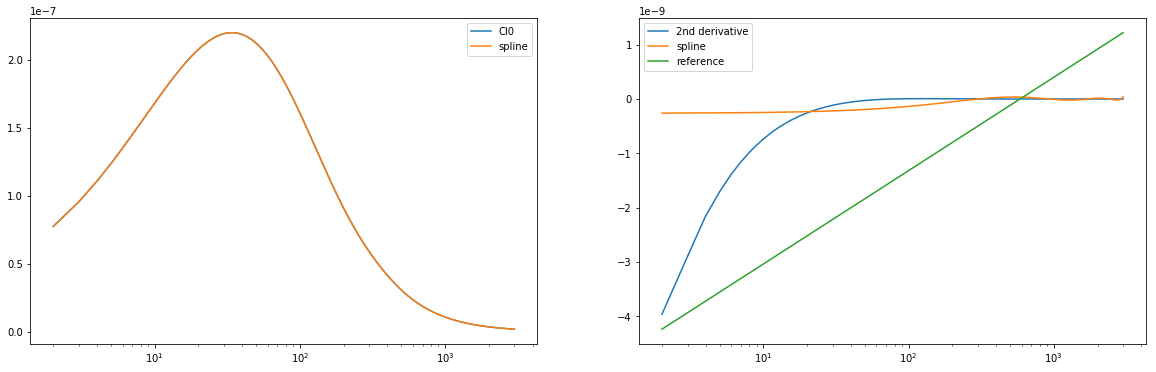

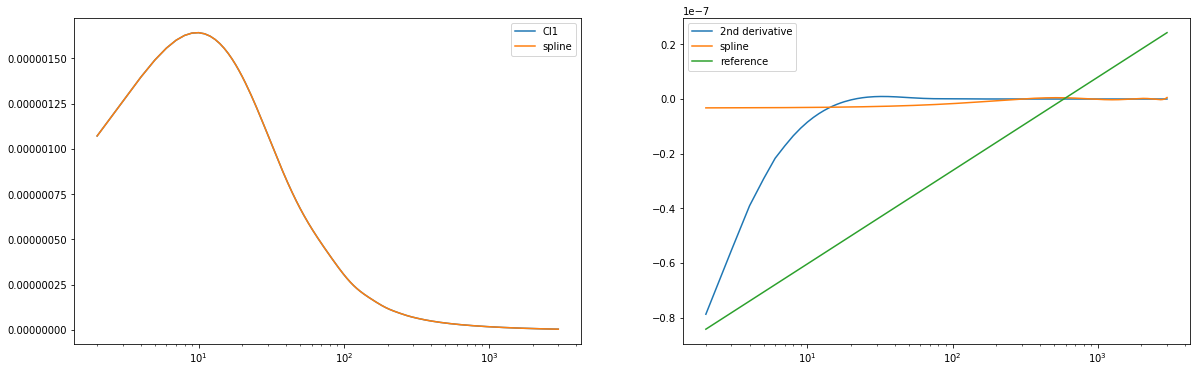

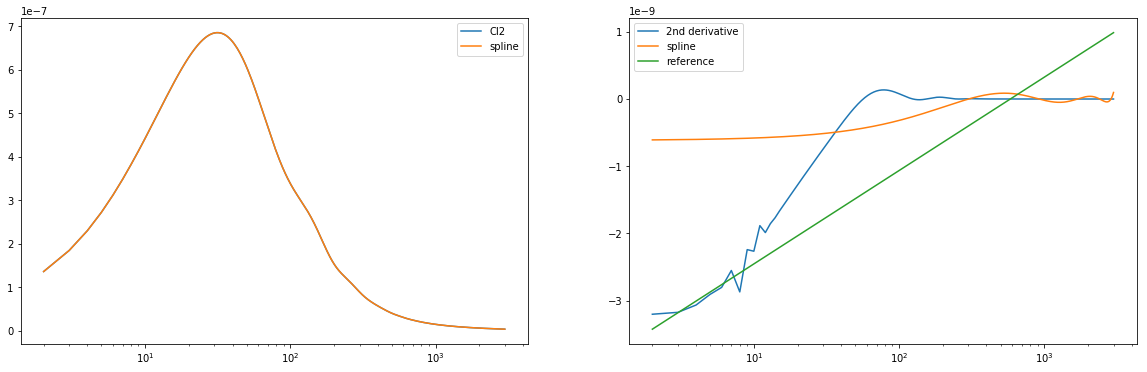

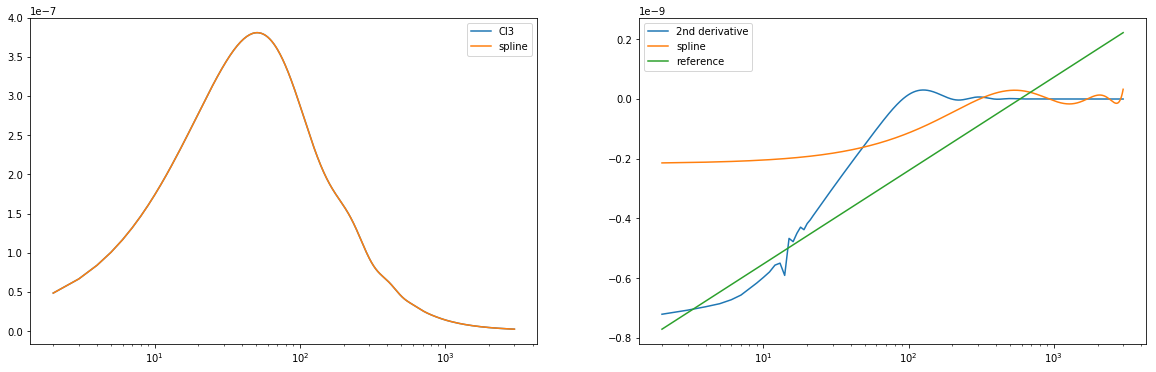

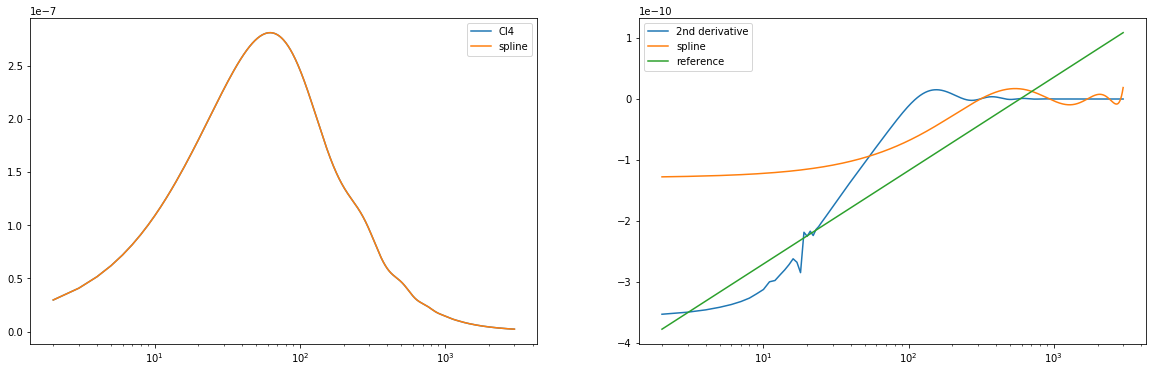

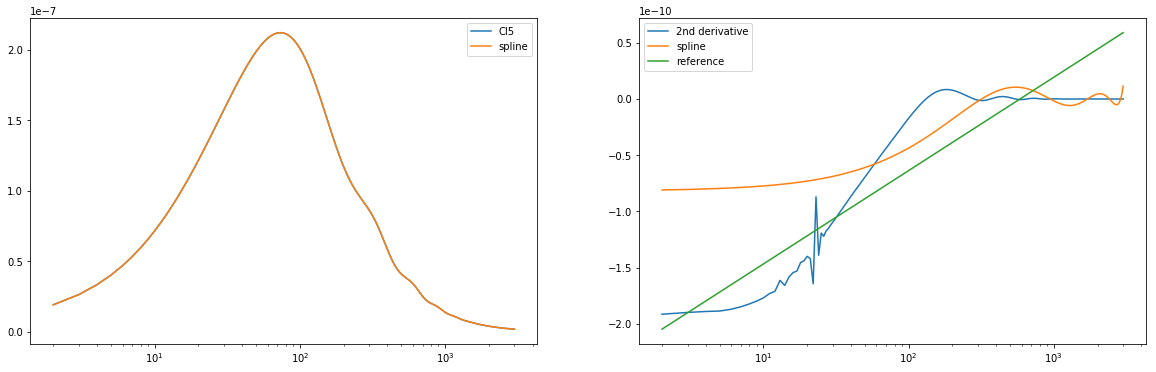

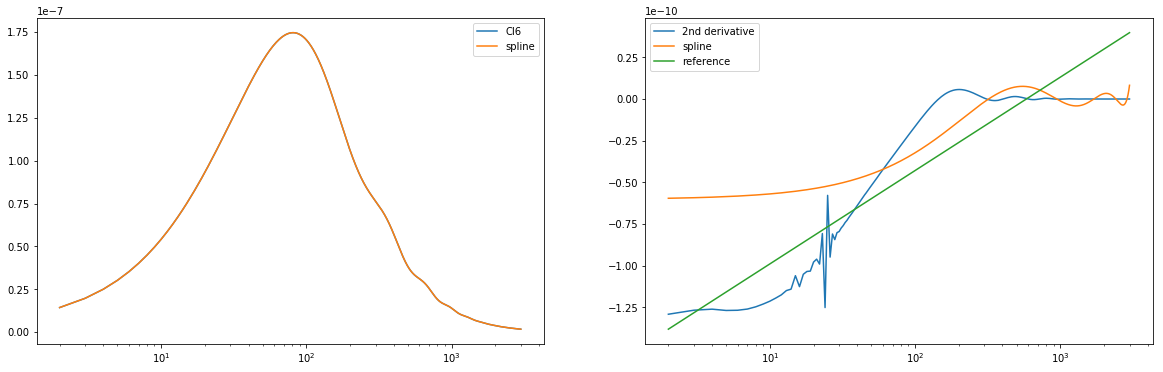

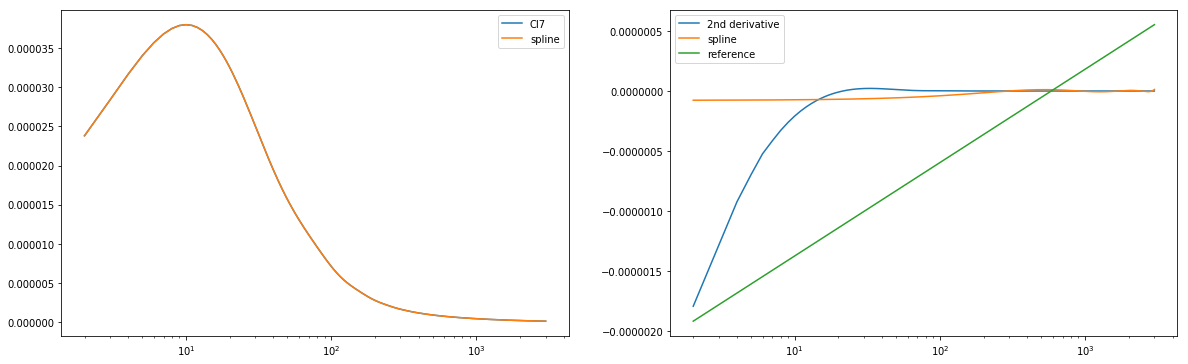

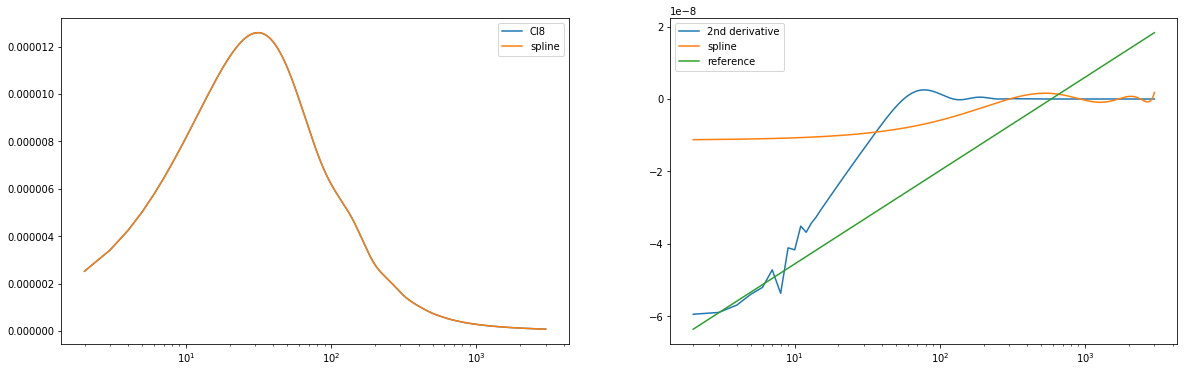

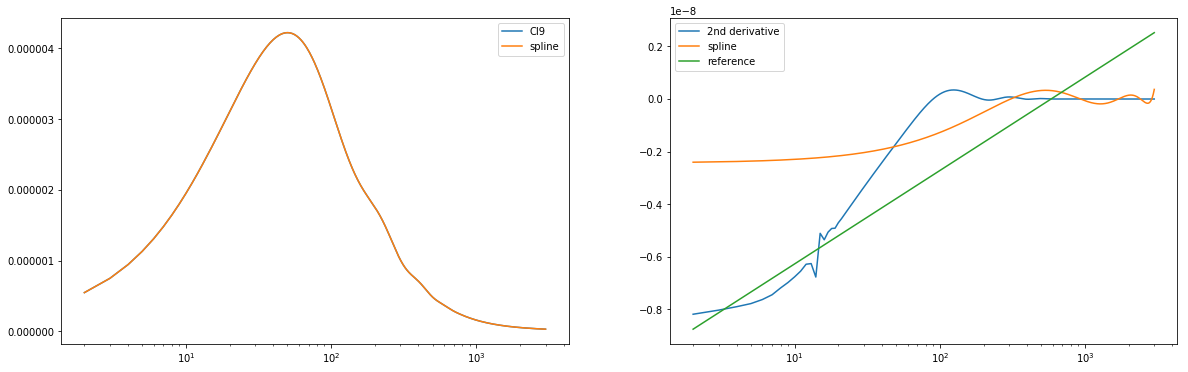

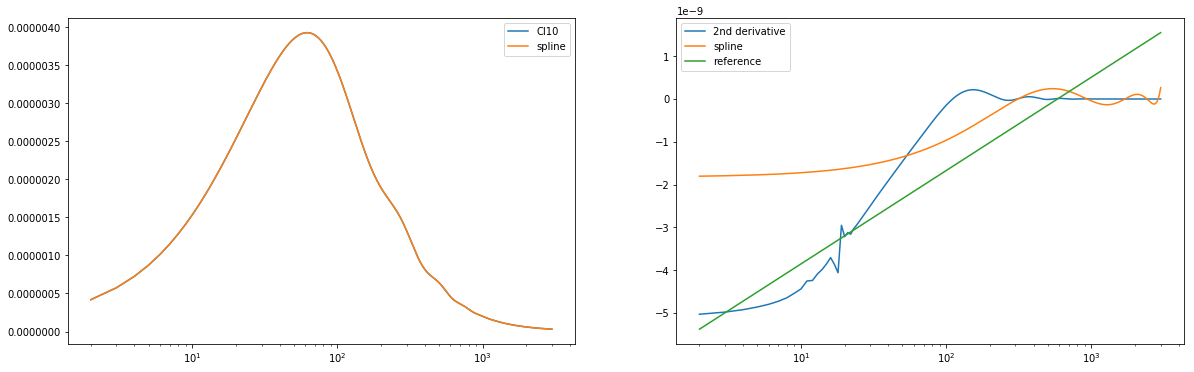

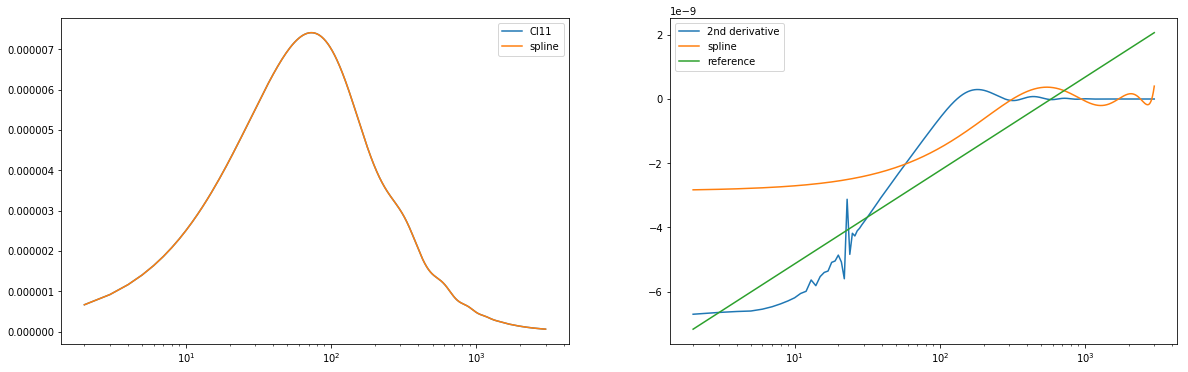

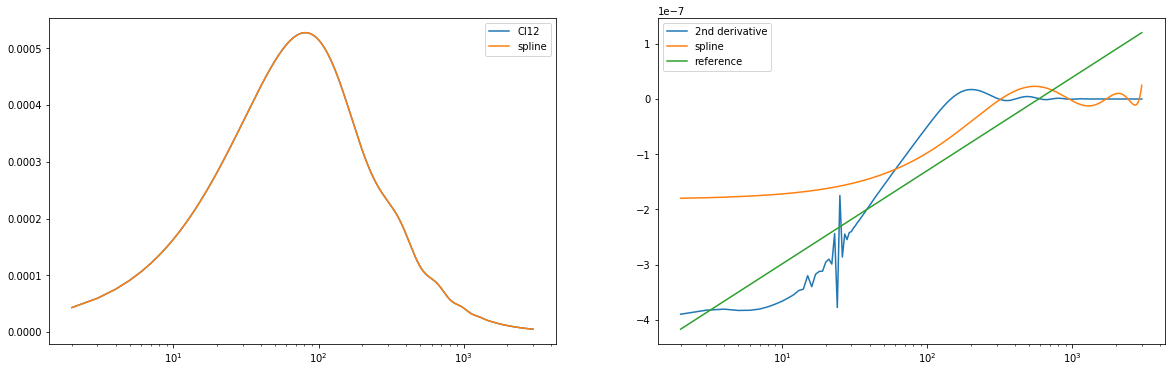

In [46]:
doFit = True
from scipy.interpolate import UnivariateSpline
if doFit:
    #nCls = nMaps*(nMaps+1)/2
    nCls = nBins*2+1 #kk,kg,gg
    nElls = Fobj2.lmax-Fobj2.lmin+1
    splines = np.empty((nCls,nElls)) 
    secondDs = np.empty((nCls,nElls)) 
    splines2 = np.empty((nCls,nElls)) 
    myElls = Fobj2.ells
    
    # collect the Cls to differentiate
    myCls = [Fobj2.crossCls[0,0]]  #kk
    for binNum in range(nBins):    #kg
        myCls.append(Fobj2.crossCls[0,binNum+1])
    for binNum in range(nBins):    #gg
        myCls.append(Fobj2.crossCls[binNum+1,binNum+1])
        
    # differentiate them
    for clNum in range(nCls):
        y_spl = UnivariateSpline(myElls,myCls[clNum],s=0,k=4)
        splines[clNum] = y_spl(myElls)
        y_spl_2d = y_spl.derivative(n=2)
        secondDs[clNum] = y_spl_2d(myElls)
        
        # get fit to 2nd derivative
        y_spl2 = UnivariateSpline(myElls,secondDs[clNum],k=5)
        splines2[clNum] = y_spl2(myElls)
        
        
    # plot the splines and derivatives
    for clNum in range(nCls):
        f, axarr = plt.subplots(1,2,figsize=(20,6)) 
        plt.sca(axarr[0])
        #plt.plot(myElls,myCls[clNum],label='Cl{0}'.format(clNum))
        #plt.plot(myElls,splines[clNum],label='spline')
        plt.semilogx(myElls,myCls[clNum],label='Cl{0}'.format(clNum))
        plt.semilogx(myElls,splines[clNum],label='spline')
        plt.legend()
        title = 'Cl number {0}'.format(clNum)
        
        plt.sca(axarr[1])
        plt.semilogx(myElls,secondDs[clNum],label='2nd derivative')
        plt.semilogx(myElls,splines2[clNum],label='spline')
        plt.semilogx(myElls,secondDs[clNum][0]*1.2-np.log(myElls)*secondDs[clNum][0]/np.log(myElls[200]),label='reference')
        plt.legend()
        title = 'Cl number {0} 2nd derivative'.format(clNum)
        
        plt.show()
    

In [100]:
# enough of fancy lines that don't fit.
# pick something simple and go with it
# remember I'm throwing out ell<30 anyway
# sampling frequencies:
#   10<=ell<30 : level 5:  every 2 ell: 10 total
#   30<=ell<50 : level 4:  every 5 ell: 4 total
#   50<=ell<100 : level 3: every 10 ell: 5 total
#   100<=ell<600: level 2: every 25 ell: 20 total
#   600<=ell<2000: level 1: every 70 ell: 20 total
#   2000<=ell<=3000: level 0: every 100 ell: 11 total
#
# make it so
ells1 = np.arange(10)*2+10
print ells1
ells2 = np.arange(4)*5+30
print ells2
ells3 = np.arange(5)*10+50
print ells3
ells4 = np.arange(20)*25+100
print ells4
ells5 = np.arange(20)*70+600
print ells5
ells6 = np.arange(11)*100+2000
print ells6

ellsSet = np.append(ells1,np.append(ells2,np.append(ells3,np.append(ells4,np.append(ells5,ells6)))))
print '\n',ellsSet

[10 12 14 16 18 20 22 24 26 28]
[30 35 40 45]
[50 60 70 80 90]
[100 125 150 175 200 225 250 275 300 325 350 375 400 425 450 475 500 525
 550 575]
[ 600  670  740  810  880  950 1020 1090 1160 1230 1300 1370 1440 1510
 1580 1650 1720 1790 1860 1930]
[2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000]

[  10   12   14   16   18   20   22   24   26   28   30   35   40   45
   50   60   70   80   90  100  125  150  175  200  225  250  275  300
  325  350  375  400  425  450  475  500  525  550  575  600  670  740
  810  880  950 1020 1090 1160 1230 1300 1370 1440 1510 1580 1650 1720
 1790 1860 1930 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000]


# Check accuracy of interpolation based on these points

In [101]:
# get Cl points
subCls = np.empty((nCls,ellsSet.size))
print subCls.shape
for ellIndex, myEll in enumerate(ellsSet):
    ellIndex2 = np.where(ells == myEll)
    #print ellIndex,ellIndex2[0][0]
    for clNum in range(nCls):
        subCls[clNum][ellIndex] = myCls[clNum][ellIndex2]

(13, 70)


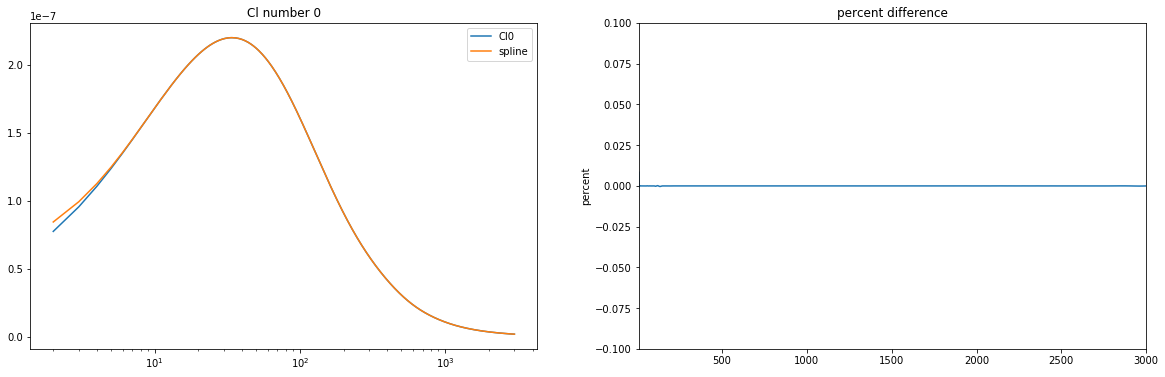

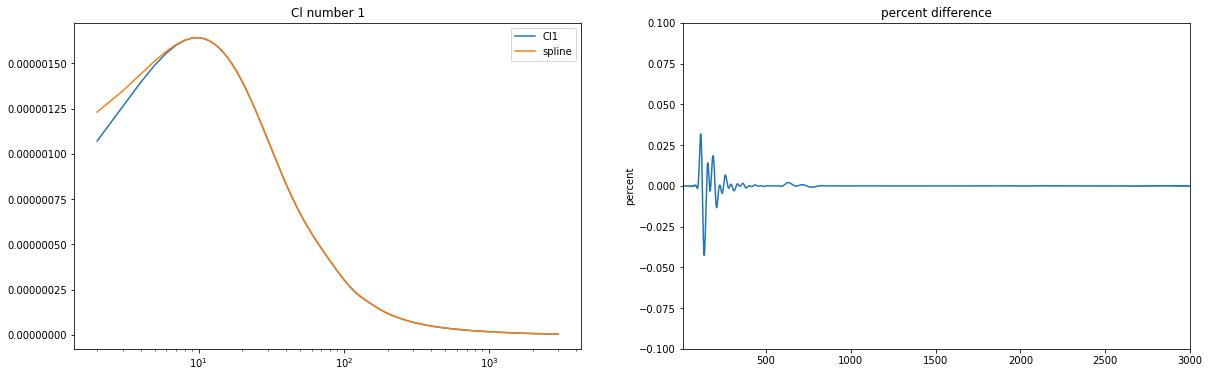

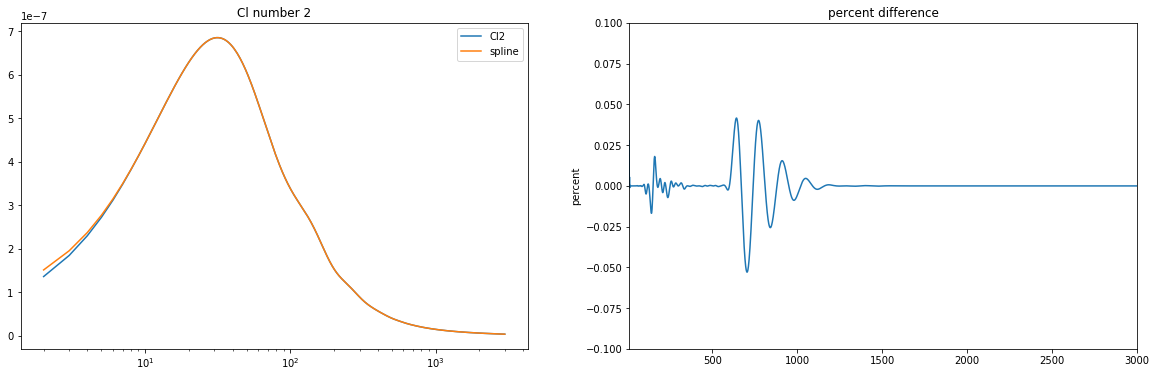

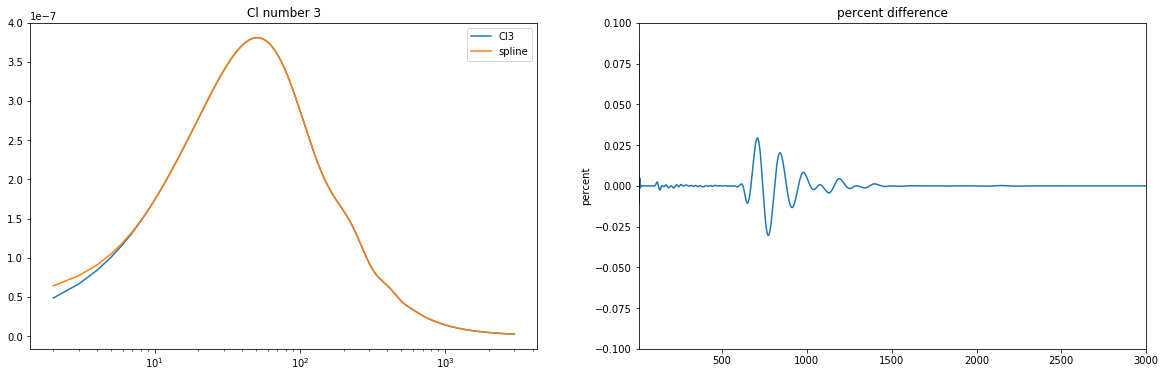

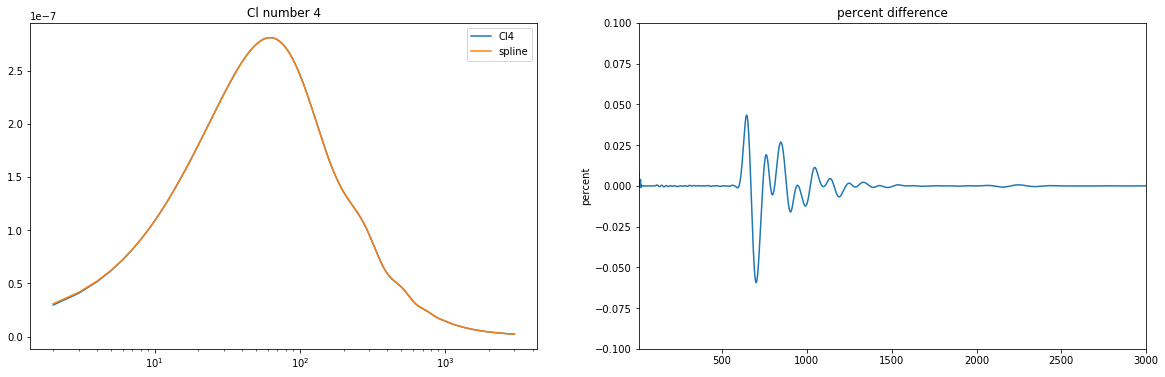

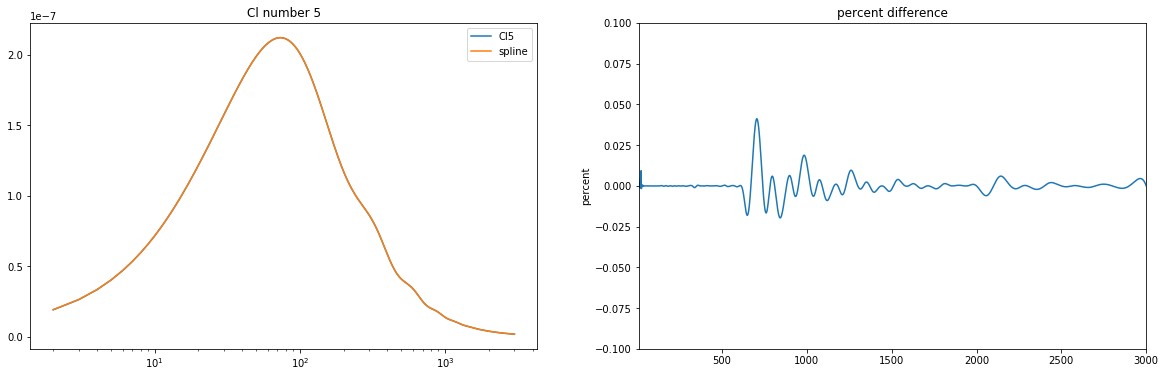

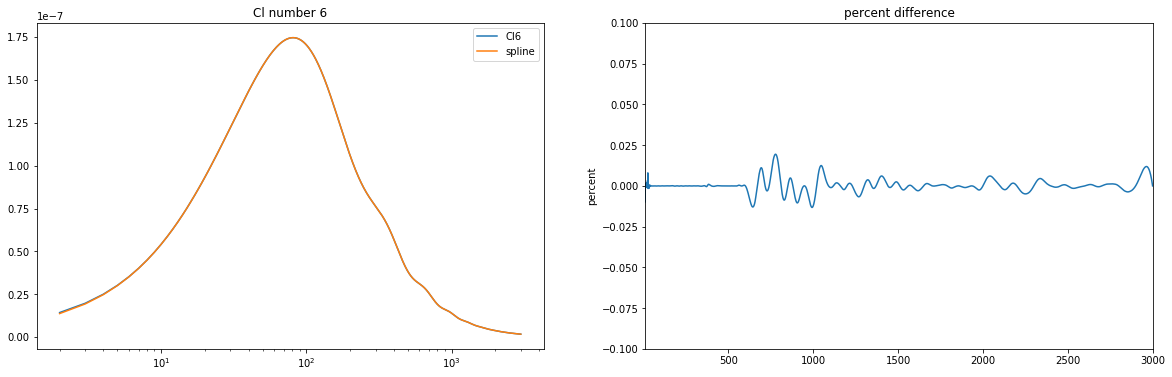

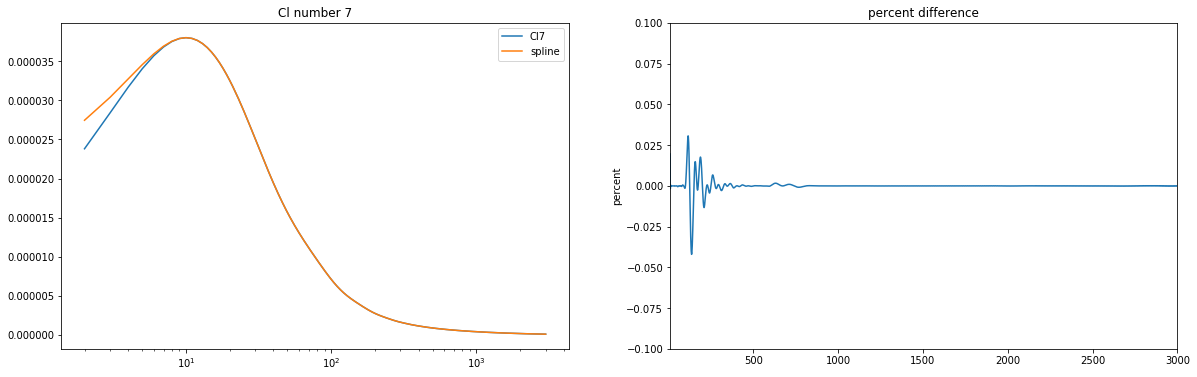

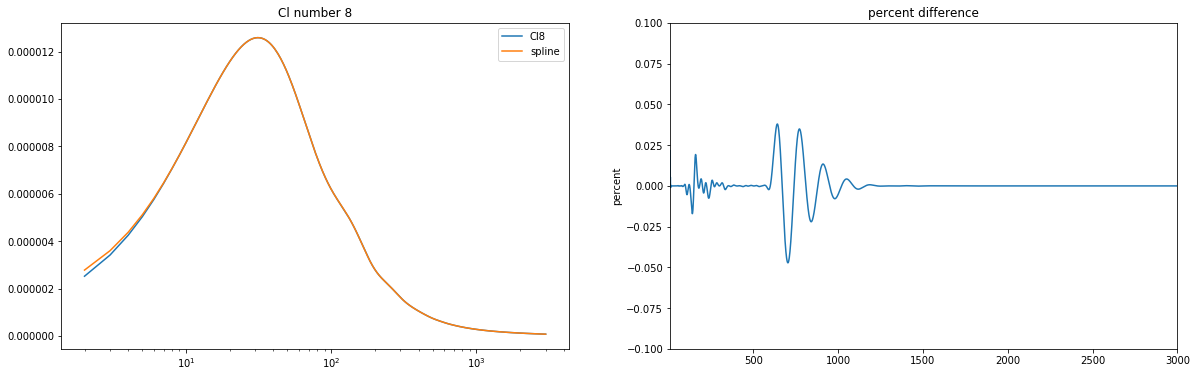

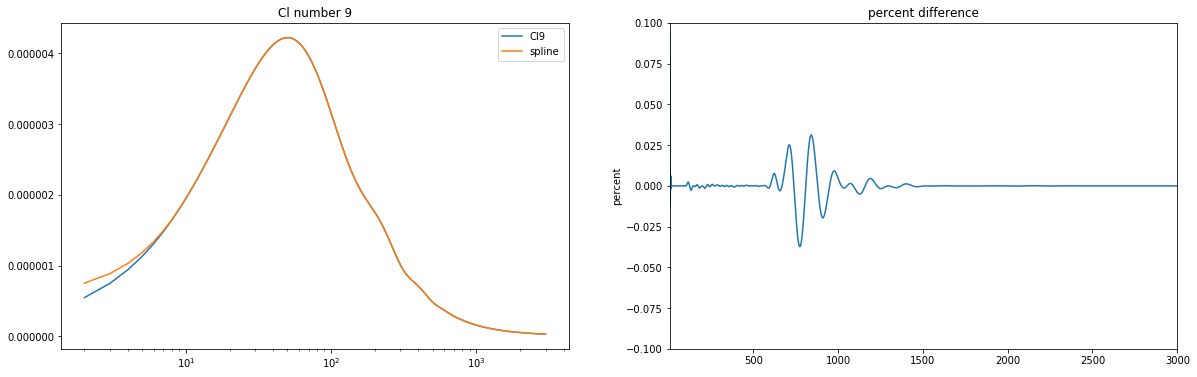

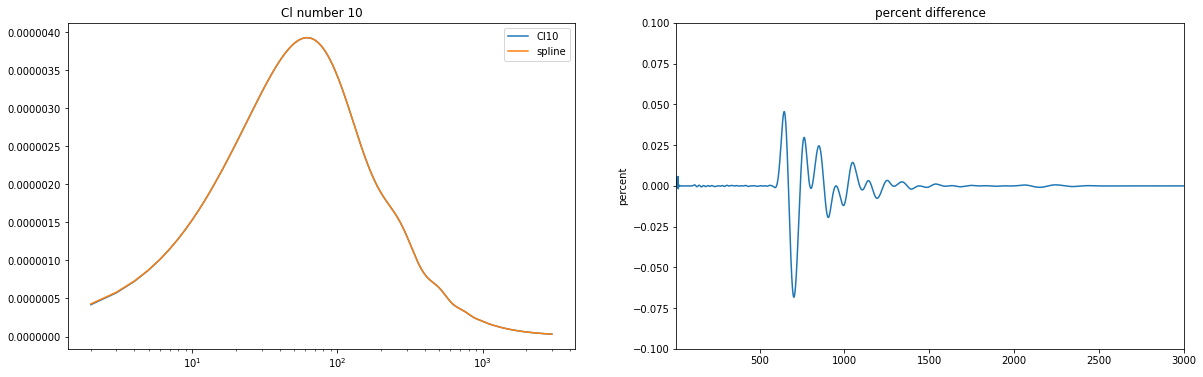

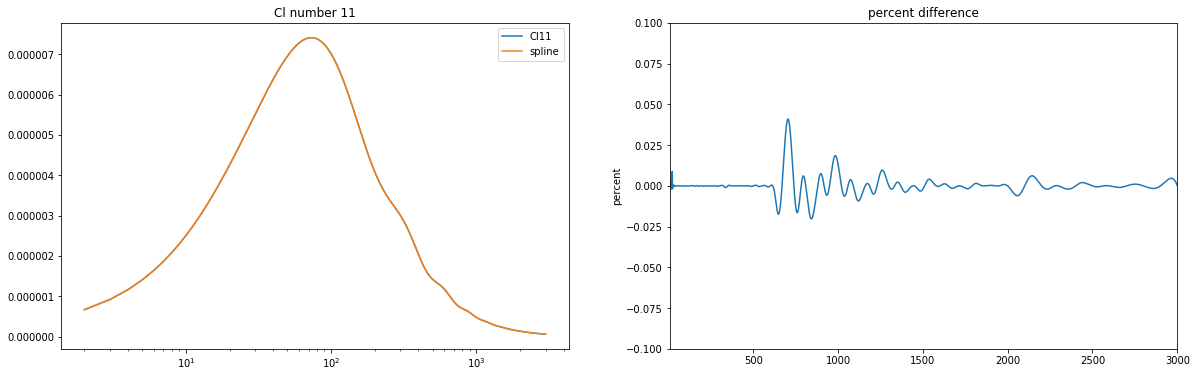

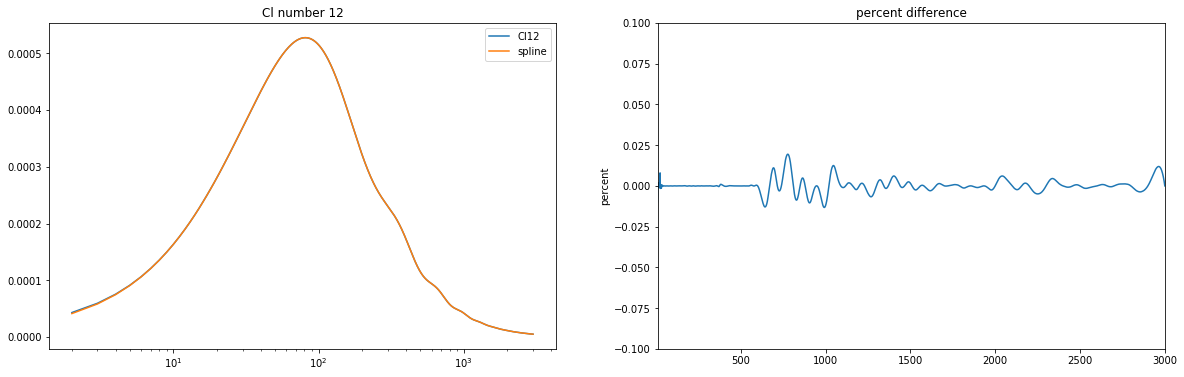

In [105]:
# get interpolation
interpCls = []
for clNum in range(nCls):
    y_spl = UnivariateSpline(ellsSet,subCls[clNum],s=0,k=4)
    interpCls.append(y_spl(myElls))
    
# plot with original
for clNum in range(nCls):
    f, axarr = plt.subplots(1,2,figsize=(20,6)) 
    plt.sca(axarr[0])
    plt.semilogx(myElls,myCls[clNum],label='Cl{0}'.format(clNum))
    plt.semilogx(myElls,interpCls[clNum],label='spline')
    plt.legend()
    plt.title('Cl number {0}'.format(clNum))

    plt.sca(axarr[1])
    #plt.semilogx(myElls,(interpCls[clNum]-myCls[clNum])/myCls[clNum]*100)
    plt.plot(myElls,(interpCls[clNum]-myCls[clNum])/myCls[clNum]*100)
    plt.ylabel('percent')
    plt.title('percent difference')
    plt.ylim((-0.1,0.1))
    plt.xlim((10,3000))
    
    plt.show()
    

# Test the new getCl function that uses interpolation

In [150]:
reload(cp)

# get MatterPower object
myPk = cp.MatterPower(nz=300000,nonlinear=True,AccuracyBoost=3)
# get Window object
myWin = cp.Window(myPk,z0=0.5,nBins=6) # set nBins to 6 if using beesBins=True in cp.tophat

print 'done.'

neutrino_hierarchy =  normal
zs.size:  299998
calculating window  0 ... 
calculating window  1 ... 
calculating window  2 ... 
calculating window  3 ... 
calculating window  4 ... 
calculating window  5 ... 
calculating window  6 ... 
done.


In [151]:
# run the getCl routine
import time
#reload(cp) # doing the reload after making Window object causes error

startTime = time.time()
# testing with kk
#ls,testCl = cp.getCl(myPk,myWin,useInterp=True)
#ls,testCl = cp.getCl(myPk,myWin,useInterp=False)
# testing with kg2
ls,testCl = cp.getCl(myPk,myWin,binNum2=2,cor2=cp.Window.galaxies,useInterp=True)
#ls,testCl = cp.getCl(myPk,myWin,binNum2=2,cor2=cp.Window.galaxies,useInterp=False)

endTime = time.time()

duration = endTime-startTime
print 'time elapsed: ',duration,' seconds'
print '          or: ',duration/60.,' minutes'
print '          or: ',duration/3600.,' hours'


window  1 : kappa  0
window  2 : galaxies  2
time elapsed:  20.4904649258  seconds
          or:  0.341507748763  minutes
          or:  0.00569179581271  hours


In [152]:
"""
record of times

Standard, unmodified getCl(myPk,myWin):
with kk:
time elapsed:  631.26363802  seconds
          or:  10.5210606337  minutes
          or:  0.175351010561  hours
2nd run:
time elapsed:  701.688681841  seconds
          or:  11.694811364  minutes
          or:  0.194913522734  hours
with kg2:
time elapsed:  592.552537918  seconds
          or:  9.87587563197  minutes
          or:  0.164597927199  hours

modified via interpolation:
with kk:
time elapsed:  15.8881168365  seconds
          or:  0.264801947276  minutes
          or:  0.00441336578793  hours
2nd run:
time elapsed:  19.5100929737  seconds
          or:  0.325168216228  minutes
          or:  0.00541947027047  hours
with kg2:
time elapsed:  20.4904649258  seconds
          or:  0.341507748763  minutes
          or:  0.00569179581271  hours

Using first run of each:
This is a factor of 0.0251 better!  It's 39.73 times faster!
12 day calculation reduces to 7.3 hours.  Sweet.



"""

"\nrecord of times\n\nStandard, unmodified getCl(myPk,myWin):\nwith kk:\ntime elapsed:  631.26363802  seconds\n          or:  10.5210606337  minutes\n          or:  0.175351010561  hours\n2nd run:\ntime elapsed:  701.688681841  seconds\n          or:  11.694811364  minutes\n          or:  0.194913522734  hours\nwith kg2:\ntime elapsed:  592.552537918  seconds\n          or:  9.87587563197  minutes\n          or:  0.164597927199  hours\n\nmodified via interpolation:\nwith kk:\ntime elapsed:  15.8881168365  seconds\n          or:  0.264801947276  minutes\n          or:  0.00441336578793  hours\n2nd run:\ntime elapsed:  19.5100929737  seconds\n          or:  0.325168216228  minutes\n          or:  0.00541947027047  hours\nwith kg2:\n\n\nUsing first run of each:\nThis is a factor of 0.0251 better!  It's 39.73 times faster!\n12 day calculation reduces to 7.3 hours.  Sweet.\n\n\n\n"

In [153]:
# save for later; uncomment one at a time
#slowCl = testCl
#fastCl = testCl

(2499,)


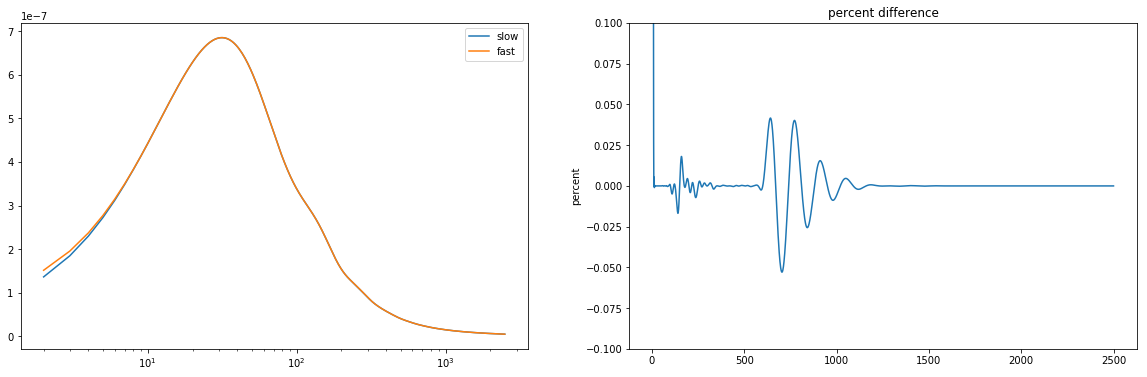

In [154]:
# plot them
ells = np.arange(2,2500+1)
print ells.shape

f, axarr = plt.subplots(1,2,figsize=(20,6)) 
plt.sca(axarr[0])
plt.semilogx(ells,slowCl,label='slow')
plt.semilogx(ells,fastCl,label='fast')
plt.legend()

plt.sca(axarr[1])
plt.plot(ells,(fastCl-slowCl)/slowCl*100)
plt.ylabel('percent')
plt.title('percent difference')
plt.ylim((-0.1,0.1))
   
plt.show()